In [1]:
import os
import pandas as pd

In [2]:
os.chdir(r'C:\Users\1\Desktop\프로젝트 로스만 상점 분석\data-20210622T012156Z-001')

In [3]:
train = pd.read_csv("lspoons_train.csv")
test = pd.read_csv("lspoons_test.csv")
store = pd.read_csv("store.csv")

train = pd.get_dummies(columns=['StateHoliday'], data=train)
test = pd.get_dummies(columns= ['StateHoliday'], data=test)

In [4]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,14929,85,2015-05-01,11360,1,0,0,1,0,0
1,14930,512,2015-05-01,10534,1,0,0,1,0,0
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0
3,14932,1,2015-04-30,6228,1,0,1,0,0,0
4,14933,9,2015-04-30,9717,1,0,1,0,0,0


In [5]:
test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

In [6]:
# Date 변수를 활용한 FE

train['Date'] = pd.to_datetime( train['Date'] )
test['Date'] = pd.to_datetime( test['Date'] )

train['weekday'] = train['Date'].dt.weekday
test['weekday'] = test['Date'].dt.weekday

train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

## * pandas에서 날짜 계산을 편리하게 하기 위하여. pd.to_datetime 함수를 통해 date 컬럼을 날짜형 변수로 바꿔줍니다.
## dt.weekday , dt.year , df month 통하여 요일 , 년도 , 월 을 뽑아낼 수 있습니다.

In [7]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,weekday,year,month
0,14929,85,2015-05-01,11360,1,0,0,1,0,0,4,2015,5
1,14930,512,2015-05-01,10534,1,0,0,1,0,0,4,2015,5
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0,4,2015,5
3,14932,1,2015-04-30,6228,1,0,1,0,0,0,3,2015,4
4,14933,9,2015-04-30,9717,1,0,1,0,0,0,3,2015,4


In [8]:
train[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']]

,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,weekday,year,month
0,1,0,0,1,0,0,4,2015,5
1,1,0,0,1,0,0,4,2015,5
2,1,0,0,1,0,0,4,2015,5
3,1,0,1,0,0,0,3,2015,4
4,1,0,1,0,0,0,3,2015,4
...,...,...,...,...,...,...,...,...,...
62239,1,1,1,0,0,0,4,2014,8
62240,1,1,1,0,0,0,4,2014,8
62241,1,1,1,0,0,0,4,2014,8
62242,1,1,1,0,0,0,4,2014,8


In [9]:
## 베이스 라인 모델링(xgboost)
!pip install xgboost

In [10]:
from xgboost import XGBRegressor

In [11]:
xgb = XGBRegressor( n_estimators= 300 , learning_rate=0.1 , random_state=2020 )
xgb.fit(train[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']],
        train['Sales'])

test['Sales'] = xgb.predict(test[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']])
test[['id','Sales']].to_csv("submission.csv",index=False)

xgb.feature_importances_

input_var = ['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']

imp_df = pd.DataFrame({"var": input_var,
                       "imp":xgb.feature_importances_})

imp_df = imp_df.sort_values(['imp'],ascending=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

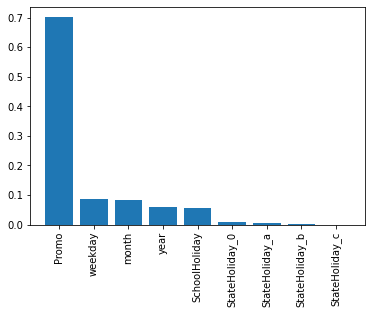

In [12]:
import matplotlib.pyplot as plt
plt.bar(imp_df['var'],imp_df['imp'])
plt.xticks(rotation=90)

In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)
score_list=[]
selected_varnum=[]

In [14]:
for i in range(1,10):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9


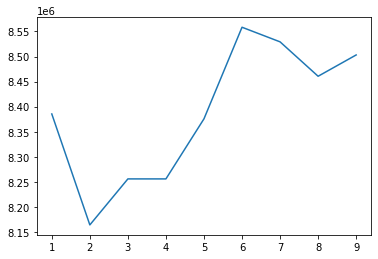

In [15]:
plt.plot(selected_varnum, score_list)

In [16]:
## input 변수를 수정해서 다시 제출 파일을 만듭니다.
xgb.fit(train[['Promo','weekday']],
        train['Sales'])
test['Sales'] = xgb.predict(test[['Promo','weekday']])
test[['id','Sales']].to_csv("submission1.csv",index=False)

In [17]:
train = pd.merge(train, store, on=['Store'], how='left')
test = pd.merge(test, store, on=['Store'], how='left')

train['CompetitionOpen'] = 12*( train['year'] - train['CompetitionOpenSinceYear'] ) + \
                             (train['month'] - train['CompetitionOpenSinceMonth'])

test['CompetitionOpen'] = 12*( test['year'] - test['CompetitionOpenSinceYear'] ) + \
                             (test['month'] - test['CompetitionOpenSinceMonth'])

train['WeekOfYear'] = train['Date'].dt.weekofyear
test['WeekOfYear'] = test['Date'].dt.weekofyear

train['PromoOpen'] = 12* ( train['year'] - train['Promo2SinceYear'] ) + \
                        (train['WeekOfYear'] - train['Promo2SinceWeek']) / 4

test['PromoOpen'] = 12* ( test['year'] - test['Promo2SinceYear'] ) + \
                        (test['WeekOfYear'] - test['Promo2SinceWeek']) / 4

## 위에서 부터 순서대로 기재

## 보조 데이터를 활용하였습니다.(store , merge)

## dt.weekofyear 함수를 통해 몇번째 주인지를 뽑는 과정을 거치고

## 프르모션이 시작된지 얼마나 되었는지를 promoopen 변수에 저장합니다.

<ipython-input-17-68bb3149adbf>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['WeekOfYear'] = train['Date'].dt.weekofyear
<ipython-input-17-68bb3149adbf>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['WeekOfYear'] = test['Date'].dt.weekofyear


In [18]:
## StoreType , Assortment , PromoInterval 변수를 one hot encoding 합니다.
train = pd.get_dummies(columns=['StoreType'],data=train)
test = pd.get_dummies(columns=['StoreType'],data=test)

train = pd.get_dummies(columns=['Assortment'],data=train)
test = pd.get_dummies(columns=['Assortment'],data=test)

train = pd.get_dummies(columns=['PromoInterval'],data=train)
test = pd.get_dummies(columns=['PromoInterval'],data=test)

In [19]:
## 2차 모델링을 위한 input 변수를 지정합니다
input_var = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [20]:
## 지정한 input 변수로 xgb 모델을 학습시킵니다.
xgb = XGBRegressor( n_estimators=300, learning_rate= 0.1, random_state=2020)
xgb.fit(train[input_var],train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
# 학습된 모델에서 변수중요도를 뽑아 imp_df라는 데이터프레임으로 저장시킵니다.
imp_df = pd.DataFrame({'var':input_var,
                       'imp':xgb.feature_importances_})
imp_df = imp_df.sort_values(['imp'],ascending=False)

score_list=[]
selected_varnum=[]

In [22]:
## 변수중요도가 중요한 순서대로 input 변수를 늘려가며 cross validation을 실행시킵니다.
## cross validation 결과물을 score_list에 저장합니다.
for i in range(1,25):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


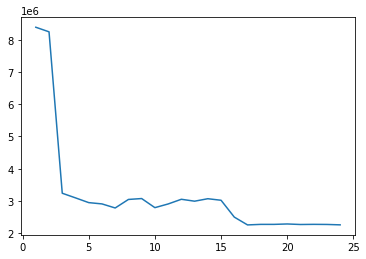

In [23]:
plt.plot(selected_varnum, score_list) ## 선택변수에 따른 cross validation score를 시각화 합니다.

In [24]:
input_var = imp_df['var'].iloc[:17].tolist()
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission2.csv",index=False)

In [25]:
estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

for i in estim_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate= 0.1, random_state=2020)
    scores = cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    print(i)

100
200
300
400
500
600
700
800
900


(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

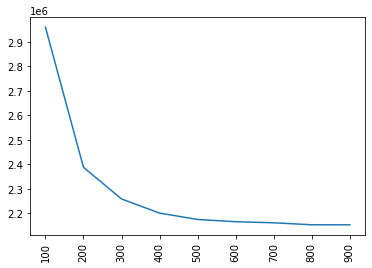

In [26]:
plt.plot(estim_list,score_list)
plt.xticks(rotation=90)

In [27]:
xgb = XGBRegressor( n_estimators=600, learning_rate= 0.1, random_state=2020)

In [28]:
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission3.csv",index=False)